In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
from autoencoder import AutoEncoder, VariationalAutoEncoder, RMS
import resources
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import PurePosixPath as Path
from tensorflow.keras.models import Model

%matplotlib inline
%load_ext autoreload
%autoreload 2

c:\Users\tomje\Anaconda3\envs\tf\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.8.0 and strictly below 2.11.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.12.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


# Load in RMS data for tests

In [2]:
# exps = ['Test 5', 'Test 7', 'Test 8', 'Test 9']
exps = ['Test 9']
rms = {}

for test in exps:
    rms[test] = RMS(test)
    rms[test].data.drop(['0', '1', '2',], axis=1, inplace=True)
    
try:
    rms['Test 5'].data.drop(['23', '24'], axis=1, inplace=True)
except KeyError:
    pass


Loaded Test 9 RMS Data


# Setup Variational Autoencoder for each Test
- The model is trained over a small section of the test depending on `train_slice`.
- The model parameters are specified within the `params` dict.

In [3]:
autoe = {}
for test in exps:
        # autoe[test] = VariationalAutoEncoder(rms[test],
        #                                    tb=False,
        #                                    tb_logdir=rms[test].exp_name,
        #                                    train_slice=(0, 50),
        #                                    random_state=1,
        #                                    params={'latent_dim': 2,
        #                                            'n_size': [32, 16],
        #                                            'epochs': 300,
        #                                            'batch_size': 20,
        #                                            'callbacks': [
        #                                                    tf.keras.callbacks.EarlyStopping(
        #                                                         monitor='val_loss',
        #                                                         patience=30,
        #                                                         mode='min',
        #                                                         start_from_epoch=100,
        #                                                    ),
        #                                                 ]
        #                                            }
        #                                    )
        autoe[test] = AutoEncoder(rms[test],
                                  tb=False,
                                  tb_logdir=rms[test].exp_name,
                                  train_slice=(0, 65),
                                  val_frac=0.1,
                                  random_state=2,
                                  params={'n_bottleneck': 5,
                                          'n_size': [32,32],
                                          'epochs': 750,
                                          'batch_size': 40,
                                          'loss': 'mse',
                                          'callbacks': [
                                                  tf.keras.callbacks.EarlyStopping(
                                                              monitor='val_loss',
                                                              patience=40,
                                                              mode='min',
                                                              start_from_epoch= 200,
                                                  ),
                                                #   tf.keras.callbacks.ReduceLROnPlateau(
                                                #                 monitor='val_loss',
                                                #                 mode='min',
                                                #                 patience=25,
                                                #                 factor=0.01,
                                                #   ),
                                                ]

                                          }
                                  )       

Pre-Processing Data:
	Training Data: slice(0, 65, None)
	Input train shape: (58, 394)
	Input val shape: (7, 394)

AUTOE-TEST_9-E-750-L-[32, 32, 5, 32, 32]-20230523-142634



In [4]:
platform = os.name
if platform == 'nt':
    onedrive = Path(r'C:\Users\tomje\OneDrive - Cardiff University')
    onedrive = onedrive.joinpath('Documents', 'PHD', 'AE')
    TB_DIR= onedrive.joinpath('Tensorboard')
elif platform == 'posix':
    onedrive = Path(r'/mnt/c/Users/tomje/OneDrive - Cardiff University')
    onedrive = onedrive.joinpath('Documents', 'PHD', 'AE')
    TB_DIR= onedrive.joinpath('Tensorboard')
print(TB_DIR)

C:\Users\tomje\OneDrive - Cardiff University/Documents/PHD/AE/Tensorboard


In [5]:
# add model checkpoint callback after creating model
for test in exps:
    name = autoe[test].run_name
    autoe[test].model.callbacks.append(
        tf.keras.callbacks.ModelCheckpoint(
        filepath=TB_DIR.joinpath('models', rms[test].exp_name, f'{name}_best.h5'),
        monitor='val_loss',
        mode='min',
        save_best_only=True,
        save_weights_only=True,
        )
    )

# Train each autoe on the training data
- `x` is the inputted data for training, which is `autoe.train_data`
- `val_data` is the validation data from `autoe.val_data`

In [7]:
for test in exps:
        autoe[test].fit(x=autoe[test].train_data,
                      val_data=autoe[test].val_data,
                      verbose=0,
                      use_multiprocessing=True,
                      )

Training:   0%|           0/750 ETA: ?s,  ?epochs/s

## Reload saved weights from best model

In [8]:
for test in exps:
    name = autoe[test].run_name
    autoe[test].model.model_.load_weights(ML_DIR.joinpath('models', rms[test].exp_name, f'{name}_best.h5'))
    autoe[test].pred = None
    autoe[test].scores = None

# Results Visualisation

## Loss plot of each trained model

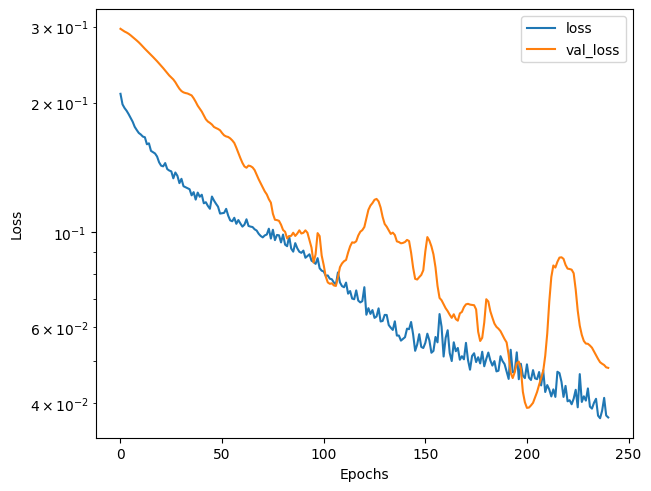

In [33]:
fig, ax = plt.subplots(1, len(exps),
                    #    figsize=(10,5),
                       constrained_layout=True,
                       )
# ax = ax.ravel()
for i, test in enumerate(exps):
    axis = fig.axes[i]
    autoe[test].loss_plot(plt_ax=axis)
    axis.set_yscale('log')
    if i > 0:
        axis.set_ylabel('')

## Score each model
- Models scored on train, validation and whole dataset

In [10]:
for test in exps:
    print(f'\n {test}')
    pred_tr, scores_tr = autoe[test].score('train')
    pred_val, scores_val = autoe[test].score('val')
    pred_data, scores_data = autoe[test].score('dataset')


 Test 9

Train Scores:
	MAE: 0.16192
	MSE: 0.04705
	R2: -0.25632

Val Scores:
	MAE: 0.15700
	MSE: 0.03899
	R2: 0.06370

Dataset Scores:
	MAE: 0.36235
	MSE: 0.29957
	R2: -0.75475


## Show histogram of scores across whole dataset

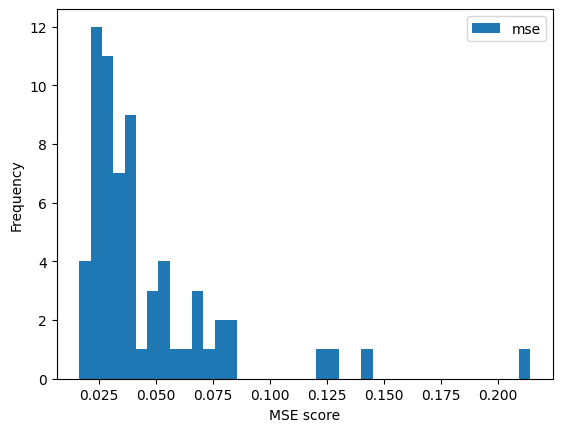

In [11]:
for test in exps:
    fig, ax = autoe[test].hist_scores(['mse'])

## Show model recreation capability of training and validation sets

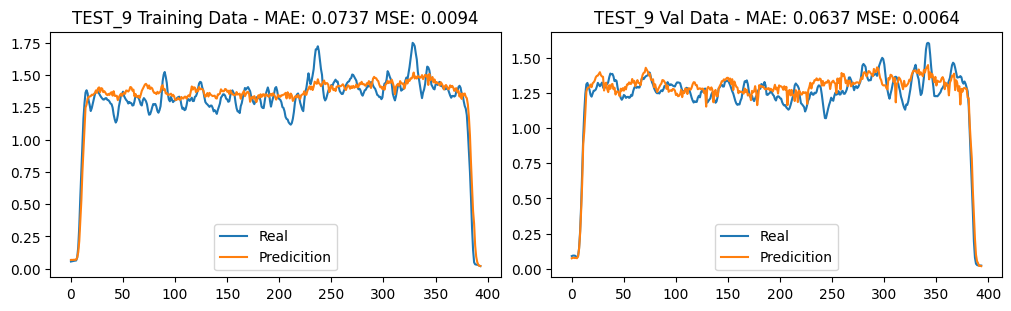

In [12]:
for test in exps:
    fig, ax = plt.subplots(1, 2, figsize=(10,3), constrained_layout=True)
    ax = ax.ravel()

    # Training plot
    ax[0] = autoe[test].pred_plot(autoe[test]._ind_tr[0], plt_ax=ax[0])
    ax[0].set_title(f'{autoe[test].RMS.exp_name} Training Data - {ax[0].get_title()}')

    # Validation plot
    ax[1] = autoe[test].pred_plot(autoe[test]._ind_val[0], plt_ax=ax[1])
    ax[1].set_title(f'{autoe[test].RMS.exp_name} Val Data - {ax[1].get_title()}')

## Thresholds for anomaly detection of each model

In [13]:
for test in exps:
    autoe[test].thres


Cutoffs:
	MAE cutoff: 0.20497
	MSE cutoff: 0.07949
	R2 cutoff: -1.04666


## Show scores against threshold

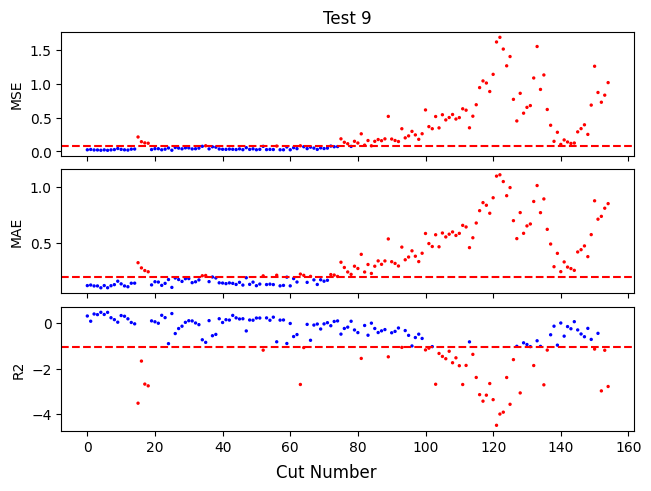

In [14]:
metrics = ['mse', 'mae', 'r2']

fig, ax = plt.subplots(len(metrics), len(exps),
                    #    figsize=(15, 5),
                       constrained_layout=True,
                    #    sharey= 'row',
                       sharex='col',
                       )
axes = fig.axes

for i, test in enumerate(exps):
    for j, met in enumerate(metrics):
        _ = autoe[test].scatter_scores([met], plt_ax=axes[(i + (j * len(exps)))])

        axes[(i)].set_title(test)
        axes[(len(exps) * j) + i].set_ylabel('')
        axes[(len(exps) * j) + i].set_xlabel('')
        if i == 0:
            axes[(len(exps) * j) + i].set_ylabel(f'{met.upper()}')

_ = fig.supxlabel('Cut Number')

In [15]:
dfs = [pd.DataFrame(autoe[test].scores) for test in exps]
df = pd.concat(dfs, keys=exps, names=['Test', 'Metrics'])
for test in exps:
    print(f'\n {test}')
    print(df.loc[test].describe())


 Test 9
              mae         mse          r2
count  155.000000  155.000000  155.000000
mean     0.362349    0.299568   -0.754747
std      0.257690    0.385989    1.106987
min      0.104968    0.016556   -4.502524
25%      0.155724    0.038316   -1.156585
50%      0.258258    0.121743   -0.410642
75%      0.540352    0.459578    0.068995
max      1.108564    1.692330    0.485817


## autoe models latent space

In [16]:
# for test in exps:
#     fig, ax = autoe[test].plot_latent_space()

## Wear measurements comparison

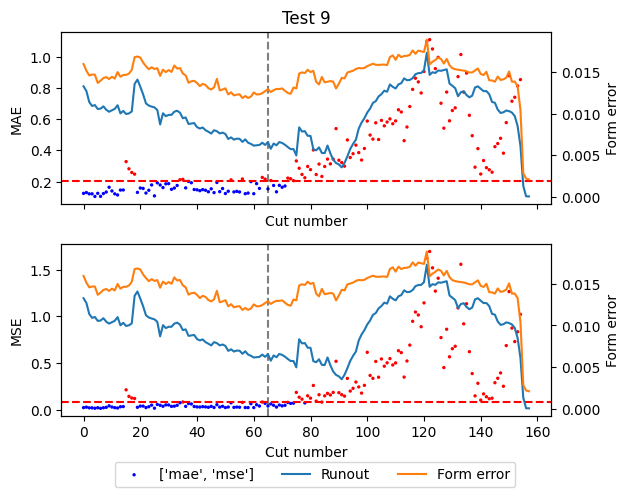

In [17]:
features = ['Runout', 'Form error']
metric = ['mae', 'mse']


fig, ax = plt.subplots(len(metric), len(exps),
                    #    figsize=(15, 6),
                       constrained_layout=True,
                    #    sharey= 'row',
                       sharex='col',
                       )

ax2 = []
for a in ax.ravel():
    ax2.append(a.twinx())

for a, b in zip(ax2[1:], ax2[0:-1]):
    a.sharey(b)

ax2 = np.reshape(ax2, ax.shape)

axes = fig.axes
axes2 = axes[-(len(axes) // 2):]
axes = axes[0:(len(axes) // 2)]
for i, test in enumerate(exps):
    axes[i].set_title(test)

    exp = resources.load(test)
    for j, met in enumerate(metric):
        _ = autoe[test].scatter_scores([met], plt_ax=axes[(i + (j * len(exps)))])

        # vert line to show where training data ends
        axes[(len(exps) * j) + i].axvline(autoe[test]._train_slice.stop,
                                    color='k',
                                    linestyle='--',
                                    alpha=0.5,
                                    )

        for feature in features:
            feat = exp.features[feature]
            axes2[(len(exps) * j) + i].plot(range(len(feat)), feat, label=feature)

        axes[(len(exps) * j) + i].set_ylabel('')
        if i == 0:
            axes[(len(exps) * j) + i].set_ylabel(f'{met.upper()}')
        if i ==len(exps) - 1:
            axes2[(len(exps) * j) + i].set_ylabel(f'{feature}')


for i, a in enumerate(axes2):
    if (i + 1) % len(exps) != 0:
        plt.setp(a.get_yticklabels(), visible=False)

l1, lab1 = axes[0].get_legend_handles_labels()
l2, lab2 = axes2[0].get_legend_handles_labels()

plt.figlegend(l1 + l2,
              [metric] + lab2, 
              loc='center', 
              bbox_to_anchor=(0.5, 0),
              ncol=len(l1 + l2)
              )
plt.tight_layout()

## Just Encoder

In [18]:

ae = autoe['Test 9'].model.model_
ae.summary()

print('\n')

encoder = Model(inputs=ae.get_layer('Encoder').input, outputs=ae.get_layer('Encoder').output)
encoder.summary()

Model: "AutoEncoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 394)]             0         
                                                                 
 Encoder (Functional)        (None, 5)                 14117     
                                                                 
 Decoder (Functional)        (None, 394)               14506     
                                                                 
Total params: 28,623
Trainable params: 28,367
Non-trainable params: 256
_________________________________________________________________


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 394)]             0         
                                                                 
 dense_6 (Dense)             (No

In [19]:
input = rms['Test 9'].data.values
input = autoe['Test 9'].scaler.transform(input.T)

encoded = encoder.predict(input, verbose=0)
print(encoded.shape)

(155, 5)


In [20]:
exp = resources.load('Test 9')
target = exp.features['Runout']
target = target.drop([0, 1, 2], axis=0).values
inputs = np.concatenate([encoded, target.reshape(-1, 1)], axis=1)
main_df = pd.DataFrame(inputs, columns=['L1', 'L2', 'L3', 'L4', 'L5', 'Target'])
main_df.head()

,L1,L2,L3,L4,L5,Target
0,0.0,0.0,0.0,0.0,0.0,0.010906
1,0.0,0.0,0.0,0.0,0.0,0.011009
2,0.0,0.0,0.0,0.0,0.0,0.010544
3,0.0,0.0,0.0,0.0,0.0,0.010585
4,0.0,0.0,0.0,0.0,0.0,0.010863


In [36]:
ml = resources.LSTM_Model(feature_df=main_df,
                          target='Target',
                          tb=False,
                          params={'seq_len': 15,
                                  'epochs': 1000,
                                  'no_nodes': 128,
                                  'batch_size': 150,
                                  'no_layers': 3,
                                  'no_dense': 1,
                                  'dropout': 0.1,
                                  'loss': 'mse',
                                  'callbacks': [tf.keras.callbacks.EarlyStopping(
                                                              monitor='val_loss',
                                                              patience=75,
                                                              mode='min',
                                                              start_from_epoch= 200,
                                                  ),
                                  ]
                                  },
                          random_state=1,
)

In [37]:
ml.fit(validation_split=0.33, verbose=0)

-----------------------------------------------------------------
LSTM-WLEN-15-E-1000-B-150-L-[128 128 128 128]-D-0.1-20230523-150410


Training:   0%|           0/1000 ETA: ?s,  ?epochs/s

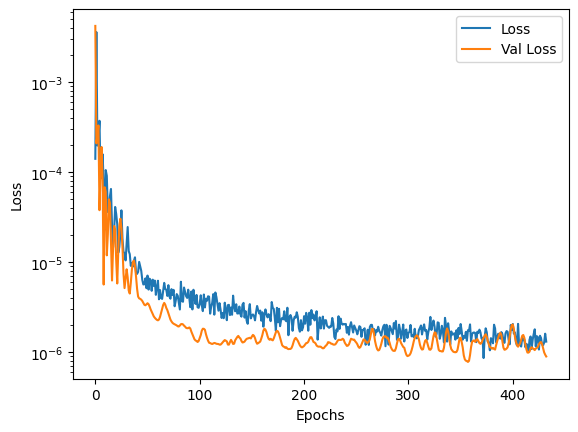

In [38]:
fig, ax = ml.loss_plot()
ax.set_yscale('log')

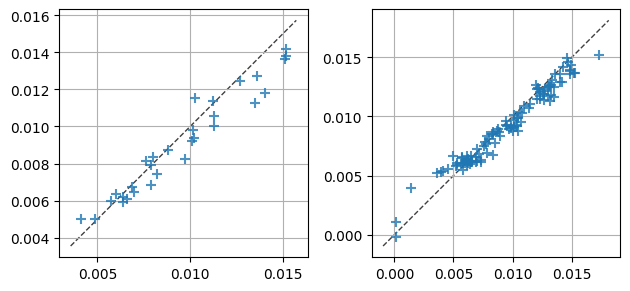

In [39]:
def pred_real_plot(y, y_pred, ax):
    ax.scatter(y, y_pred, marker='+', alpha=0.8, s=50)

    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]

    ax.set_axisbelow(True)
    ax.grid()
    ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0, linewidth=1)
    ax.set_aspect('equal')
    return ax

fig, ax = plt.subplots(1, 2)
ax[0] = pred_real_plot(ml.val_data[1], ml.model.predict(ml.val_data[0], verbose=0), ax[0])
ax[1] = pred_real_plot(ml.train_data[1], ml.model.predict(ml.train_data[0], verbose=0), ax[1])
fig.tight_layout()

In [40]:
_ = ml.score(X=ml.train_data[0],
              y=ml.train_data[1],
              plot_fig=False,
              )
_ = ml.score(plot_fig=False)

-----------------------------------------------------------------
Validation Scores:
-----------------------------------------------------------------
MAE = 0.650 um
MSE = 0.695 um^2
R^2 = 0.944
-----------------------------------------------------------------
Validation Scores:
-----------------------------------------------------------------
MAE = 0.760 um
MSE = 0.916 um^2
R^2 = 0.909
